# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

Corrections for review:
    -Label smoothing
    -Dropout in discriminator
    -One more layer in generator
    -Xavier weight initializer

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

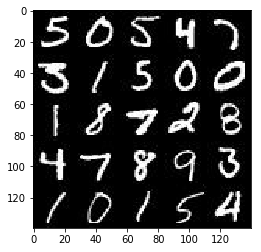

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

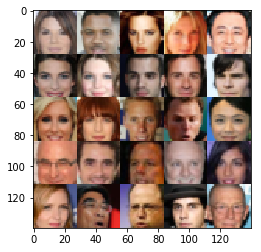

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim),  name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    dropout_rate=0.8
    
    train = not reuse
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x1 = tf.maximum(alpha*x1, x1)
        #x1 = tf.layers.dropout(x1, rate=dropout_rate, training=True)

        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #x2 = tf.layers.dropout(x2, rate=dropout_rate, training=True)
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #x3 = tf.layers.dropout(x3, rate=dropout_rate, training=True)
        
        x4 = tf.reshape(x3, (-1, 4*4* 256 ))       
        logits = tf.layers.dense(x4, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)        
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)        

        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth=0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        out_channel_dim = 3
    elif data_image_mode == "L":
        out_channel_dim = 1
        
    n_images=16
    steps=0
    print_every = 10
    show_every = 100
    
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print(input_real.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})

                
                if steps % show_every == 0:                
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 3.4778... Generator Loss: 0.0931
Epoch 1/2... Discriminator Loss: 2.5302... Generator Loss: 1.3406
Epoch 1/2... Discriminator Loss: 2.4371... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 2.2021... Generator Loss: 0.3001
Epoch 1/2... Discriminator Loss: 2.2085... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 1.8035... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 2.0306... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.8188... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.9752... Generator Loss: 0.5937


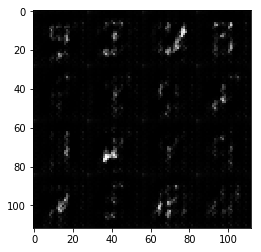

Epoch 1/2... Discriminator Loss: 1.9948... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.6578... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 0.6341


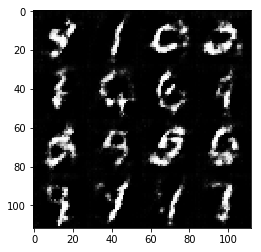

Epoch 1/2... Discriminator Loss: 1.6085... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.6269... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.7742... Generator Loss: 0.3419
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.4135
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.5804
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.5125


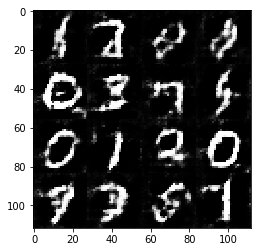

Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.5726
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.5291... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.6651... Generator Loss: 1.1673


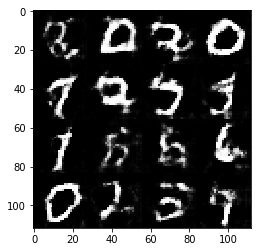

Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.4019
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 0.7979


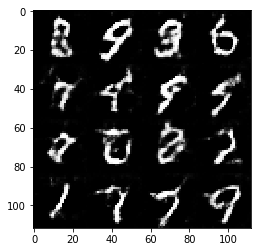

Epoch 1/2... Discriminator Loss: 1.6462... Generator Loss: 0.4178
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.5670
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.7647


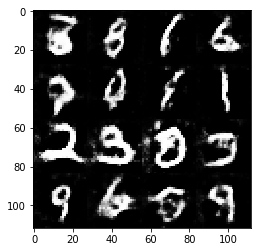

Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.4869
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.7648... Generator Loss: 0.3254
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 1.1341


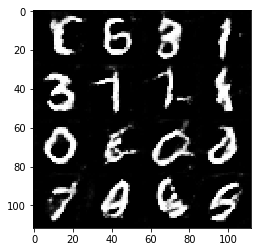

Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 2.3685... Generator Loss: 0.1527
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.4742
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 1.2279


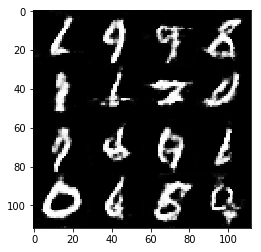

Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 1.5952... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.6028... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 1.2754
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.5711


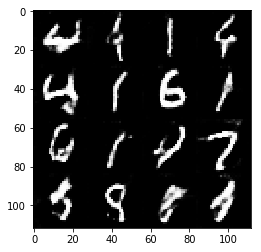

Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.5615... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 1.5338... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 2.0595... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.9954


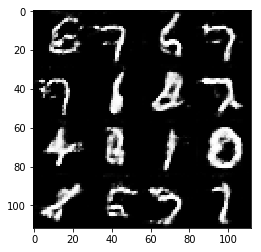

Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.5941... Generator Loss: 1.7289
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.8998... Generator Loss: 0.2573
Epoch 2/2... Discriminator Loss: 1.5383... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 0.3831
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 0.3683
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 1.0784


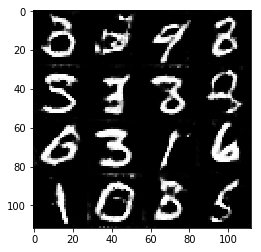

Epoch 2/2... Discriminator Loss: 1.7278... Generator Loss: 1.7197
Epoch 2/2... Discriminator Loss: 1.5245... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 1.6253... Generator Loss: 0.3776
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 1.8118... Generator Loss: 0.3087
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.8546


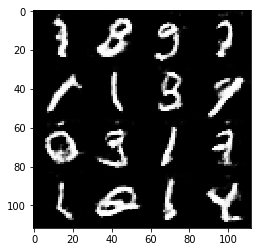

Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 1.6739... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 2.4095... Generator Loss: 0.1459
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 1.7039... Generator Loss: 0.3686


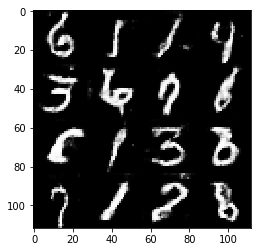

Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 1.8511
Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 1.4168... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.6358... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 1.8201


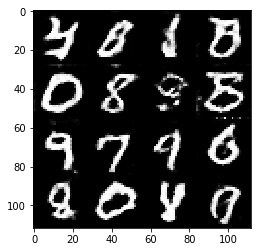

Epoch 2/2... Discriminator Loss: 1.5809... Generator Loss: 0.4249
Epoch 2/2... Discriminator Loss: 1.6379... Generator Loss: 0.3728
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 1.6143... Generator Loss: 1.5734
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 1.0398
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.6866... Generator Loss: 0.3487
Epoch 2/2... Discriminator Loss: 1.5653... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.8903


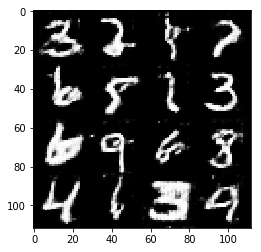

Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 1.7648... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 1.9560... Generator Loss: 2.2599
Epoch 2/2... Discriminator Loss: 1.6772... Generator Loss: 0.3594
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.7117... Generator Loss: 1.9719
Epoch 2/2... Discriminator Loss: 1.9560... Generator Loss: 0.2564
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 1.4728


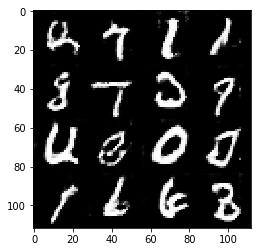

Epoch 2/2... Discriminator Loss: 1.6865... Generator Loss: 0.3827
Epoch 2/2... Discriminator Loss: 2.7324... Generator Loss: 2.6731
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.5058
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 1.2017
Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.5200
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 1.1955
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.4733


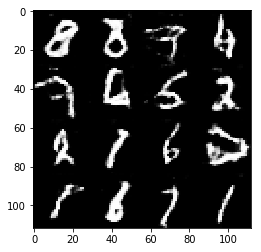

Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.5810... Generator Loss: 1.8713
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.4514
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 2.1117... Generator Loss: 0.2103


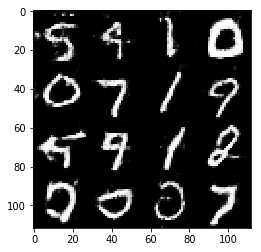

Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.5370
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.5813... Generator Loss: 0.4151
Epoch 2/2... Discriminator Loss: 1.7974... Generator Loss: 0.3386
Epoch 2/2... Discriminator Loss: 1.6630... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.8461


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 2.1551... Generator Loss: 5.9062
Epoch 1/1... Discriminator Loss: 3.2947... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 2.0867... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.5878


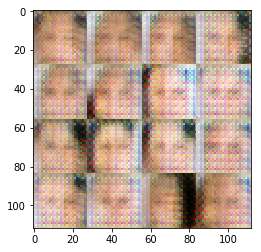

Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.7994


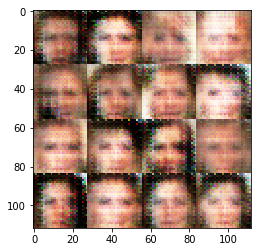

Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7609


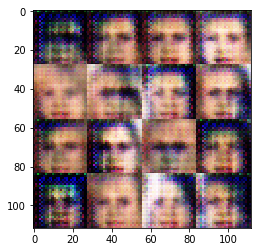

Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6031


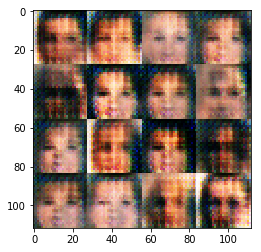

Epoch 1/1... Discriminator Loss: 1.7876... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7553


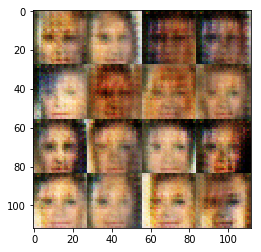

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8413


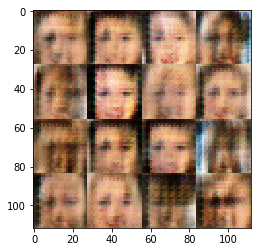

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7386


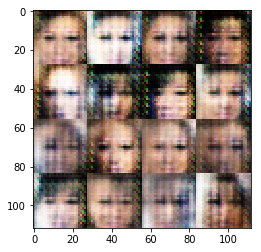

Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.9966


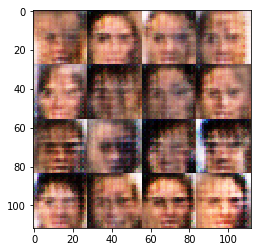

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.9003


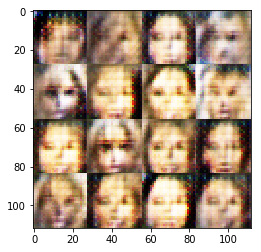

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7305


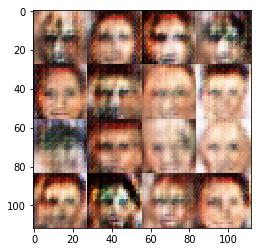

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8083


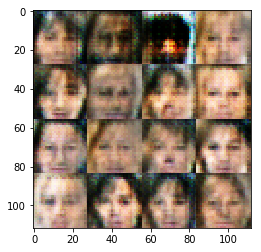

Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8341


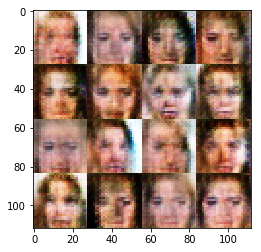

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8682


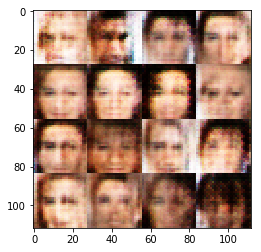

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8263


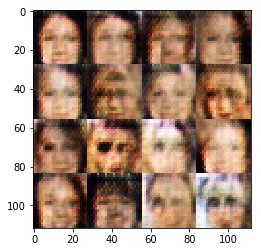

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7735


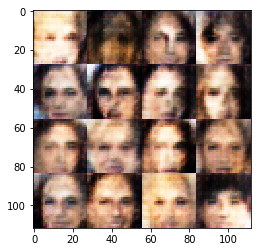

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8420


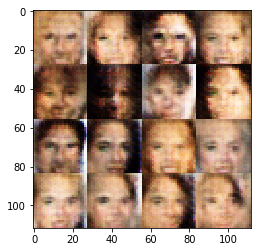

Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6707


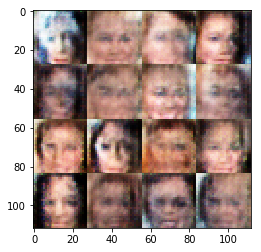

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8271


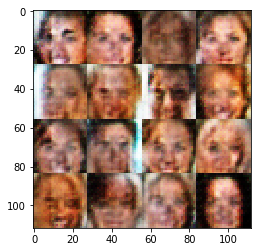

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8509


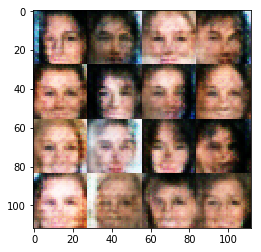

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7909


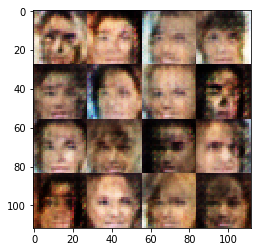

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7120


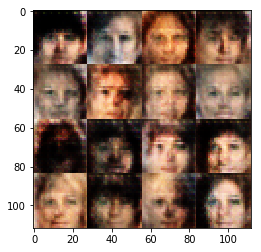

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7075


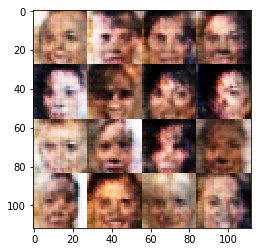

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8544


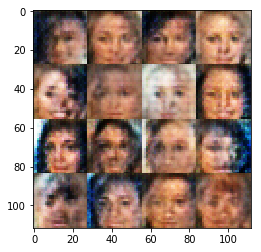

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7644


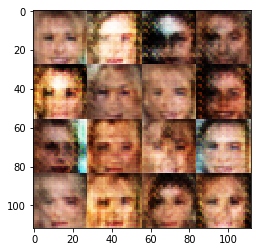

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7105


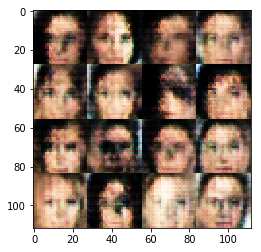

Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7926


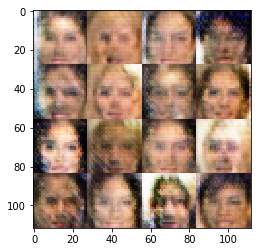

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8112


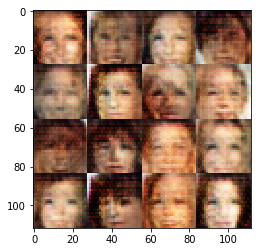

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7624


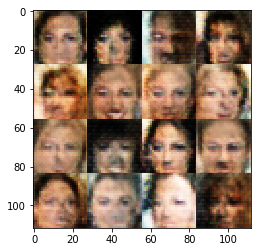

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7765


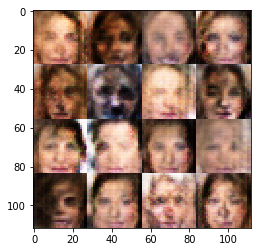

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8265


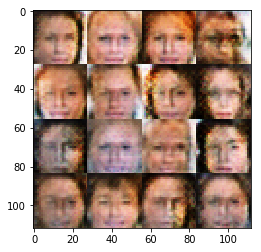

Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8281


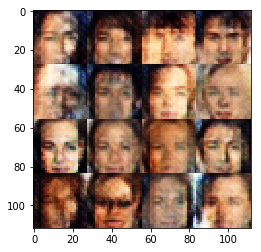

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7733


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.